<a href="https://colab.research.google.com/github/yuhi-sa/Bayes_startup/blob/main/stratup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


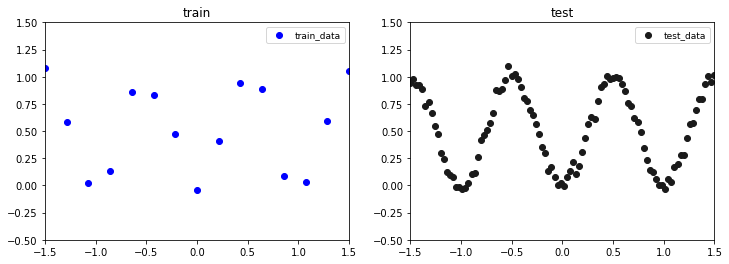

In [79]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

dataset = np.load('drive/MyDrive/Research/startup/dataset.npz')

# トレーニングデータ
x_train = dataset['x_train']
y_train = dataset['y_train']
# print(x_train.size)
# print(y_train.size)

# テストデータ
x_test = dataset['x_test']
y_test = dataset['y_test']
# print(x_test.size)
# print(y_test.size)

# データセットプロット
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x_train, y_train, label='train_data', color='b')
ax[1].scatter(x_test, y_test, label='test_data', color='0.1')
ax[0].set_title('train')
ax[1].set_title('test')
ax[0].set_xlim(-1.5, 1.5)
ax[0].set_ylim(-0.5, 1.5)
ax[1].set_xlim(-1.5, 1.5)
ax[1].set_ylim(-0.5, 1.5)
ax[0].legend(loc='upper right', fontsize=9)
ax[1].legend(loc='upper right', fontsize=9)
plt.show()

# 基底関数

高次多項式への回帰を考える

In [62]:
def phi(x):
    return [x, x**2, x**3 ,x**4, x**5 ,x**6 ,x**7, x**8, x**9]

# 最小二乗推定

最小二乗推定は，回帰モデルによる予測誤差の二乗和$S(w)$を最小化する$\hat{w}$を求める手法である．  
$S(w)$を$w$で偏微分し，$\hat{w}$を求める．
$$
S(w)=\epsilon^{T}\epsilon=(y-\Phi w)^T(y-\Phi w)
$$
$$
\frac{dS(w)}{dw}=-\Phi^{T}y+\Phi^T\Phi w
$$
$\frac{dS(w)}{dw}=0$のときを考えると，
$$
\hat{w}=(\Phi^T\Phi)^{-1}\Phi^{T}y \tag{1}
$$
従って，最小二乗推定による予測モデルは以下のようになる．
$$
\hat{y}=\Phi\hat{w}=\Phi(\Phi^T\Phi)^{-1}y \tag{2}
$$

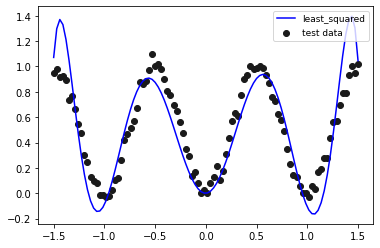

In [63]:
# 式(1)を求める
PHI = np.array([phi(x) for x in x_train])
w = np.dot(np.linalg.inv(np.dot(PHI.T, PHI)), np.dot(PHI.T, y_train))

# 式(2)を求める
PHI = np.array([phi(x) for x in x_test])
y_predict =np.dot(PHI,w.T)

# プロット
def graphPlot(x, y, label):
  plt.plot(x, y, label=label, color='b')
  plt.scatter(x_test, y_test, label="test data", color='0.1')
  plt.legend(loc='upper right', fontsize=9)
  plt.show()

graphPlot(x_test, y_predict, "least_squared")

# 最尤推定

最尤推定は，尤度$P(y,w)$を最大化する$\hat{w}$を求める手法である．誤差項に正規分布を仮定したモデルを考える．  
このとき観測値$y$は平均$\Phi w$，分散行列$\sigma^2I_n$のn次元正規分布に従う．よって尤度は，以下のように与えられる．
$$
  y= \Phi w+ \epsilon,\epsilon \sim \mathcal{N}(0,\sigma^2I_n) 
$$
- 尤度
$$
P(y\mid w,\sigma^2)=\mathcal{N}(\Phi w,\sigma^2I_n)
=\frac{1}{(2\pi\sigma^2)^{\frac{n}{2}}}exp\{-\frac{1}{2\sigma^2}(y-\Phi w)^T(y-\Phi w)\} 
$$
$P(y\mid w)$の対数を$w$で偏微分し，$\hat{w}$を求める．
$$
\log P(y\mid w) = -\frac{n}{2}\log(2\pi\sigma^2)-\frac{(y-\Phi w)^T(y-\Phi w)}{2\sigma^2}
$$
$$
\frac{1}{P(y\mid w)}\frac{P(y\mid w)}{dw}=-(\Phi^{T}y+\Phi^{T}\Phi w)
$$

$\frac{dP(y\mid w)}{dw}=0$のときを考えると．
$$
\hat{w}=(\Phi^T\Phi)^{-1}\Phi^{T}y \tag{3}
$$
従って，最尤推定による予測モデルは以下のようになる．
$$
\hat{y}=\Phi\hat{w}=\Phi(\Phi^T\Phi)^{-1}y \tag{4}
$$

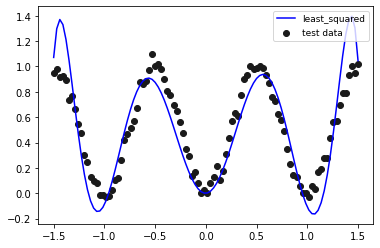

In [64]:
# 式3を求める
PHI = np.array([phi(x) for x in x_train])
w = np.dot(np.linalg.inv(np.dot(PHI.T, PHI)), np.dot(PHI.T, y_train))

# 式4を求める
PHI = np.array([phi(x) for x in x_test])
y_predict =np.dot(PHI,w.T)

# プロット
def graphPlot(x, y, label):
  plt.plot(x, y, label=label, color='b')
  plt.scatter(x_test, y_test, label="test data", color='0.1')
  plt.legend(loc='upper right', fontsize=9)
  plt.show()

graphPlot(x_test, y_predict, "least_squared")

# MAP推定

最小二乗法，最尤推定に基づく方法では，モデルパラメータの数が多く，観測データの数が小さい時に過学習を起こしやすいという問題点がある．過学習が生じると，汎化性能が期待できないため，過学習を防ぐことが重要となる．MAP推定は，$w$を確率変数として扱う．
$w$の事前分布と観測データの尤度関数を以下のように導入する．$\alpha$,$\beta$はハイパーパラメータとする．

- 事前確率
$$
P(w;\alpha)=\mathcal{N}(w\mid0,\alpha^{-1}I_n)
$$
- 尤度
$$
P(y \mid w;\beta)=\mathcal{N}(\Phi w,\beta^{-1}I_n)
$$

MAP推定では，$w$の事後分布$P(w \mid y)$を最大化する$\hat{w}$を求める手法である．

- ベイズの定理
$$
事後確率 = \frac{尤度　＊　事前確率}{P(y)}
$$

$$
P(w \mid y)=\frac{P(y \mid w)P(w)}{P(y)}
$$

ここで．$P(y|w)$は尤度を，$P(w)$は事前確率を表す．

$$
P(w \mid y)=\frac{\frac{1}{(2\pi \beta^{-1})^{\frac{n}{2}}}exp\{-\frac{1}{2\beta^2}(y-\Phi w)^T(y-\Phi w)\} \frac{1}{(2\pi \alpha^{-1})^{\frac{n}{2}}}exp\{-\frac{1}{2\alpha^2}w^{T}w\} }{P(y)}
$$

$$
P(w \mid y)=\frac{
			\frac{1}{ (2\pi)^{n}(\alpha\beta)^{-\frac{n}{2}}} 
			\exp\{
            -\frac{1}{2\beta^2} (y-\Phi w)^T(y-\Phi w)    -     \frac{1}{2\alpha^2} w^{T}w 
            \}
            }{P(y)}
$$

$P(w \mid y)$を最大化する$\hat{w}$は，
$$
Z=-\frac{1}{2\beta^2} (y-\Phi w)^T(y-\Phi w) -\frac{1}{2\alpha^2} w^{T}w 
$$
を最大化する$\hat{w}$に等しい．
$$
\frac{dZ}{dw}=-\frac{1}{2\beta^{-1}}(-\Phi^T+\Phi^T\Phi w)- \frac{1}{2 \alpha^{-1}}w^{T}w
$$

$\frac{dZ}{dw}=0$のときを考えると，

$$
\hat{w}=(-\frac{\alpha}{\beta}I_n+\Phi^T\Phi)^{-1}\Phi^{T}y \tag{5}
$$
従って，MAP推定による予測モデルは以下のようになる．

$$
\hat{y}=\Phi\hat{w}=\Phi(-\frac{\alpha}{\beta}I_n+\Phi^T\Phi)^{-1}\Phi^{T}y \tag{6}
$$


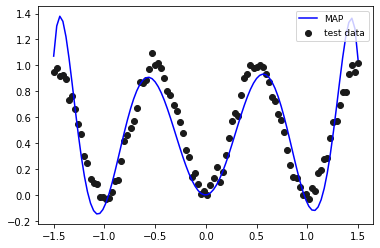

In [65]:
#ハイパーパラメータ
alpha = 10
beta =10

# 式5を求める
PHI = np.array([phi(x) for x in x_train])
w = np.dot(np.linalg.inv((alpha/beta)+np.dot(PHI.T,PHI)),np.dot(PHI.T,y_train))

# 式6を求める
import math
PHI = np.array([phi(x) for x in x_test])
u = np.dot(np.linalg.inv(-(alpha/beta)+np.dot(PHI.T,PHI)),np.dot(PHI.T,y_test))
sigma = np.linalg.inv(alpha + beta*np.dot(PHI.T,PHI))
y_predict =np.dot(PHI,w.T)

# プロット
def graphPlot(x, y, label):
  plt.plot(x, y, label=label, color='b')
  plt.scatter(x_test, y_test, label="test data", color='0.1')
  plt.legend(loc='upper right', fontsize=9)
  plt.show()

graphPlot(x_test, y_predict, "MAP")

最小二乗法，最尤推定，MAP推定では，パラメータの推定値を一つの解として求めた．しかし，これではデータの予測にパラメータの不確かさを考慮することができない．事後分布をそのまま確率分布として取り扱うことで，パラメータ推定の不確かさを加味した予測分布を求める．MAP推定では，$P(w \mid y)$の最大化を考えたため，$P(D)$については無視できたが，ベイズ推定では考える必要がある．同時確率$P(y,w)$から一方の確率変数を取り除き，周辺確率$P(y)$を求める．

$$
P(y)=\int P(y\mid w)P(w)dw
$$
$$
P(w \mid y) = \frac{P(y \mid w)P(w)}{\int P(y\mid w)P(w)dw}
$$
ここで，ガウス分布に対するベイズの定理より，
$$
P(w \mid y) = \mathcal{N}(\mu_N,\Sigma_N)
$$
ガウス分布の周辺分布と条件付き分布を用いて計算すると
$$
\Sigma_{N}=(\alpha I_n + \beta \Phi^{T}\Phi)^{-1}
$$
従って，以上よりベイズ推定による予測モデルは以下のようになる．

$$
p(\hat{y}|y;\alpha,\beta)=\mathcal{N}(\Phi\mu_N,\beta^{-1}+\Phi\Sigma_N\Phi^T) \tag{7}
$$

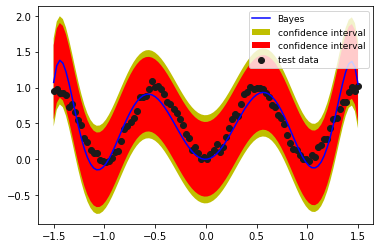

In [85]:
#ハイパーパラメータ
alpha = 10
beta =10

PHI = np.array([phi(x) for x in x_train])
w = np.dot(np.linalg.inv((alpha/beta)+np.dot(PHI.T,PHI)),np.dot(PHI.T,y_train))

# 式7を求める
PHI = np.array([phi(x) for x in x_test])
u = np.dot(np.linalg.inv((alpha/beta)+np.dot(PHI.T,PHI)),np.dot(PHI.T,y_test))
y_predict =np.dot(PHI,w.T)

# 式8を求める
sigma = np.linalg.inv(alpha + beta*np.dot(PHI.T,PHI))
sigma2 = 1/beta - np.dot(np.dot(PHI,sigma),PHI.T)

# 信頼度区間を設定する
s = np.mean(np.sqrt(sigma2))

# プロット
def graphPlot(x, y, label, s):
  plt.plot(x, y, label=label, color='b')
  # 95%信頼区間
  t = 1.95*s
  predict_upper = y + t
  predict_lower = y - t
  plt.fill_between(x_test, predict_upper, predict_lower,label='confidence interval', facecolor='y')
  # 65%信頼区間
  t = 1.65*s
  predict_upper = y + t
  predict_lower = y - t
  plt.fill_between(x_test, predict_upper, predict_lower,label='confidence interval', facecolor='r')
  plt.scatter(x_test, y_test, label="test data", color='0.1')
  plt.legend(loc='upper right', fontsize=9)
  plt.show()

graphPlot(x_test, y_predict, "Bayes", s)